In [19]:
!pip install kagglehub --quiet
!pip install tensorflow --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install nltk --quiet

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Suppress warnings
import warnings, os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smcha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Download dataset
import os

path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")
for root, dirs, files in os.walk(path):
    print(root)
    for f in files:
        print("  ", f)
        
# Load the CSV files
import glob

fake_file = glob.glob(os.path.join(path, '**', 'Fake.csv'), recursive=True)[0]
true_file = glob.glob(os.path.join(path, '**', 'True.csv'), recursive=True)[0]

fake_df = pd.read_csv(fake_file)
true_df = pd.read_csv(true_file)
print("Loaded:", fake_file, "and", true_file)

# Add labels
fake_df['label'] = 0
true_df['label'] = 1

# Combine and shuffle
data = pd.concat([fake_df, true_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print("Total samples:", len(data))
data.head()

C:\Users\smcha\.cache\kagglehub\datasets\emineyetm\fake-news-detection-datasets\versions\1
C:\Users\smcha\.cache\kagglehub\datasets\emineyetm\fake-news-detection-datasets\versions\1\News _dataset
   Fake.csv
   True.csv
Loaded: C:\Users\smcha\.cache\kagglehub\datasets\emineyetm\fake-news-detection-datasets\versions\1\News _dataset\Fake.csv and C:\Users\smcha\.cache\kagglehub\datasets\emineyetm\fake-news-detection-datasets\versions\1\News _dataset\True.csv
Total samples: 44898


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [22]:
# Combine title and text columns if available
if 'title' in data.columns and 'text' in data.columns:
    data['content'] = data['title'].astype(str) + ' ' + data['text'].astype(str)
elif 'text' in data.columns:
    data['content'] = data['text'].astype(str)
else:
    raise ValueError("Dataset must have 'text' or ('title' and 'text') columns")

# Drop missing or duplicate entries
data = data.dropna(subset=['content'])
data = data.drop_duplicates(subset=['content'])
print("Data cleaned. Remaining samples:", len(data))

Data cleaned. Remaining samples: 39105


In [23]:
# Basic text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # keep only letters
    text = text.lower()  # lowercase
    text = text.split()
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

data['clean_text'] = data['content'].apply(clean_text)
data.head()

,title,text,subject,date,label,content,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls th circuit court committed cou...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,Trump drops Steve Bannon from National Securit...,trump drops steve bannon national security cou...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,Donald Trump heads for Scotland to reopen a go...,donald trump heads scotland reopen golf resort...


In [24]:
# Tokenize and pad sequences
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['clean_text'])
sequences = tokenizer.texts_to_sequences(data['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

labels = data['label'].values

print("Tokenization complete. Example sequence:")
print(sequences[0][:10])

Tokenization complete. Example sequence:
[1642, 3007, 479, 616, 2191, 42, 1010, 1789, 1, 754]


In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (31284, 200) Test shape: (7821, 200)


In [26]:
# Build LSTM Model
embedding_dim = 128

model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=1
)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.7992 - loss: 0.4542 - val_accuracy: 0.9233 - val_loss: 0.2602
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 141s 718ms/step - accuracy: 0.8911 - loss: 0.3161 - val_accuracy: 0.8822 - val_loss: 0.3340
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 139s 711ms/step - accuracy: 0.9346 - loss: 0.2226 - val_accuracy: 0.8964 - val_loss: 0.3160
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 141s 719ms/step - accuracy: 0.9280 - loss: 0.2250 - val_accuracy: 0.9529 - val_loss: 0.1635
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 718ms/step - accuracy: 0.9312 - loss: 0.2086 - val_accuracy: 0.9733 - val_loss: 0.0949


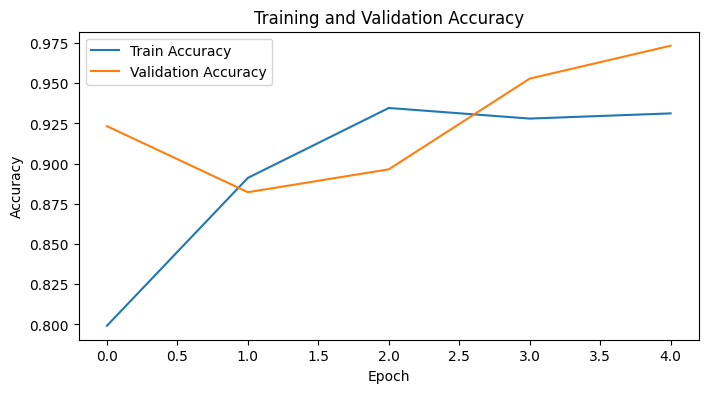

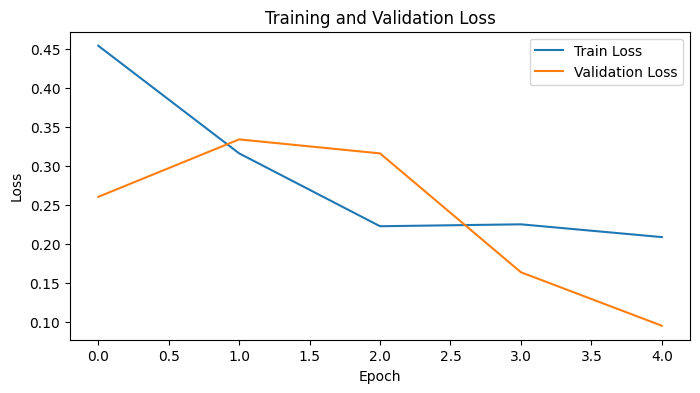

In [28]:
# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step
Test Accuracy: 0.9712313003452244


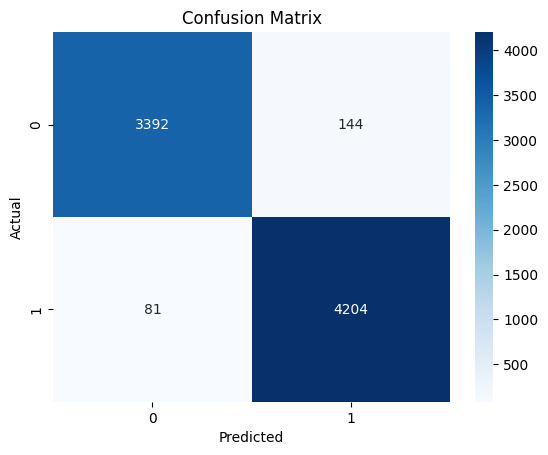


Classification Report:
               precision    recall  f1-score   support

        Fake       0.98      0.96      0.97      3536
        Real       0.97      0.98      0.97      4285

    accuracy                           0.97      7821
   macro avg       0.97      0.97      0.97      7821
weighted avg       0.97      0.97      0.97      7821



In [29]:
# Evaluate on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

In [40]:
# Test with custom input
def predict_news(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(pad)[0][0]
    label = 'Real' if pred > 0.5 else 'Fake'
    print(f"Prediction: {label} ({pred:.2f})")

# Try some examples
predict_news("Government announces new policy for education reform.")
predict_news("Aliens have landed on Earth, scientists confirm shocking news!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Prediction: Real (0.97)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Prediction: Fake (0.05)
